In [1]:
import pandas as pd
import pickle
from pathlib import Path
import os
import pandas as pd
import scanpy as sc
import cellink as cl
from cellink.tl._burden_testing import *

/opt/modules/i12g/anaconda/envs/mzb_scgenetics/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
chr22_all_results=pd.read_pickle("/s/project/sys_gen_students/2024_2025/project04_rare_variant_sc/output/association/chr22_all_results.pkl"
                                       )

In [3]:
chr22_all_results

burden_gene      target_gene              burden_type    pvalue  \
0   ENSG00000100181  ENSG00000100181               CADD_PHRED  0.655488   
1   ENSG00000100181  ENSG00000100181                DNA_LM_up  0.603825   
2   ENSG00000100181  ENSG00000100181              DNA_LM_down  0.614145   
3   ENSG00000100181  ENSG00000100181            MAF_beta_1.25  0.740962   
4   ENSG00000100181  ENSG00000100181             DNA_LM_mixed  0.614145   
..              ...              ...                      ...       ...   
2   ENSG00000170638  ENSG00000170638              DNA_LM_down  0.029698   
3   ENSG00000170638  ENSG00000170638            MAF_beta_1.25  0.027210   
4   ENSG00000170638  ENSG00000170638             DNA_LM_mixed  0.037233   
5   ENSG00000170638  ENSG00000170638        GENE_TSS_DISTANCE  0.101223   
6   ENSG00000170638  ENSG00000170638  GENE_TSS_DISTANCE_SAIGE  0.127100   

        beta     cell_type chromosome  
0   0.001330        CD8 ET         22  
1  -0.001548        CD8 ET         22  
2  -0.001503        CD8 ET         22  
3   0.000986        CD8 ET         22  
4  -0.001503        CD8 ET         22  
..       ...           ...        ...  
2   0.564450  Erythrocytes         22  
3   0.570935  Erythrocytes         22  
4   0.541945  Erythrocytes         22  
5   0.429862  Erythrocytes         22  
6   0.397016  Erythrocytes         22  

[32501 rows x 7 columns]

### Correcting p values

In [4]:
from statsmodels.stats.multitest import multipletests

In [5]:
def FDR_correction(association_results):
    """
    association_results: pd.DataFrame, results from burden_test/ output written in run_burden_ass.py
    
    returns: - df_final: pd.DataFrame, association_results, sorted by celltype and burden type
                                        added column "FDR corrected" values and "significant"
             - df_to_plot: pd.DataFrame, summary of # significant egenes per cell type and burden type
    """
   
    df=association_results.copy()
    df_to_plot = pd.DataFrame(columns=['celltype', 'annotation', 'n'])
    
    df_final=[]
    for celltype in df["cell_type"].unique():
        df_annotations={}
        for annotation in df["burden_type"].unique():
            df_annotations[annotation] = df[(df["cell_type"] == celltype) & (df["burden_type"]==annotation)]
            df_annotations[annotation] = df_annotations[annotation].dropna(how='all')
            # FDR correction
            df_annotations[annotation]["significant"], df_annotations[annotation]["FDR_corrected"], _, _ = multipletests(df_annotations[annotation]["pvalue"], alpha=0.05, method='fdr_bh')
            
            df_to_plot = pd.concat([df_to_plot, pd.DataFrame({
                    'celltype': [celltype],
                    'annotation': [annotation],
                    'n': [len(df_annotations[annotation][df_annotations[annotation]["significant"]])]
                })], ignore_index=True)
            df_annotations[annotation]["celltype-annotation"]= f"{celltype}-{annotation}"
            df_final.append(df_annotations[annotation]) 
            
    df_final=pd.concat(df_final)
    
    df_to_plot['celltype_annotation'] = df_to_plot['celltype'] + "_" + df_to_plot['annotation']
    df_to_plot
    return df_final, df_to_plot
        

In [6]:
from plotnine import *
def plot_egenes(df_to_plot):
    """
    df_to_plot: pd.DataFrame, as output[1] of  FDR_correction()
    returns: plot, grouped barplot # egenes per cell type and burden
    """
    zero_types = list(df_to_plot.query("n==0")["celltype_annotation"])
    # Filter out the rows where `n` is 0 and create the plot
    plot = (
        ggplot(df_to_plot.query("celltype_annotation not in @zero_types"), 
               aes(x='celltype', y='n', fill='annotation'))  # Specify x, y, and fill variables
        + geom_bar(stat="identity", position="dodge")  # Use position="dodge" for grouped bars
        + theme_classic()  # Optional: use a clean theme
        + theme(
            axis_text_x=element_text(angle=45, hjust=1, vjust=1),
            figure_size=(7, 4)
        )
        + labs(
            y="Number of E-Genes", 
            x="", 
            fill="Burden Annotation"
        )
        # Optional: Customize colors manually
        # + scale_fill_manual(values=['darkred', "grey", "blue", "green"], 
        #     labels=["GENE_TSS_DISTANCE", "GENE_TSS_DISTANCE_SAIGE", "CADD_PHRED", "DNA_LM_down","DNA_LM_up","DNA_LM_mixed", "MAF_beta_1.25"])
    )
    return(plot)


In [7]:
df_final_ET, df_to_plot_ET = FDR_correction(chr22_all_results)

In [8]:
df_final_ET[df_final_ET["significant"]]

burden_gene      target_gene    burden_type        pvalue      beta  \
0   ENSG00000185608  ENSG00000185608     CADD_PHRED  4.136143e-04 -0.042982   
0   ENSG00000244752  ENSG00000244752     CADD_PHRED  9.646785e-12  0.030304   
0   ENSG00000100284  ENSG00000100284     CADD_PHRED  2.465291e-04 -0.028984   
0   ENSG00000212939  ENSG00000212939     CADD_PHRED  2.277483e-04  0.027954   
3   ENSG00000177663  ENSG00000177663  MAF_beta_1.25  6.763201e-04  0.026120   
..              ...              ...            ...           ...       ...   
4   ENSG00000100307  ENSG00000100307   DNA_LM_mixed  5.597463e-05  0.305621   
1   ENSG00000128185  ENSG00000128185      DNA_LM_up  3.650636e-04  1.107529   
2   ENSG00000128185  ENSG00000128185    DNA_LM_down  4.647649e-04  1.080518   
3   ENSG00000128185  ENSG00000128185  MAF_beta_1.25  8.510478e-04  1.061162   
4   ENSG00000128185  ENSG00000128185   DNA_LM_mixed  4.455046e-04  1.084526   

       cell_type chromosome  significant  FDR_corrected  \
0         CD8 ET         22         True   3.815592e-02   
0         CD8 ET         22         True   3.559664e-09   
0         CD8 ET         22         True   3.032307e-02   
0         CD8 ET         22         True   3.032307e-02   
3         CD8 ET         22         True   4.991242e-02   
..           ...        ...          ...            ...   
4       CD4 SOX4         22         True   1.052323e-02   
1   Erythrocytes         22         True   1.241216e-02   
2   Erythrocytes         22         True   1.580201e-02   
3   Erythrocytes         22         True   2.893563e-02   
4   Erythrocytes         22         True   1.514716e-02   

           celltype-annotation  
0            CD8 ET-CADD_PHRED  
0            CD8 ET-CADD_PHRED  
0            CD8 ET-CADD_PHRED  
0            CD8 ET-CADD_PHRED  
3         CD8 ET-MAF_beta_1.25  
..                         ...  
4        CD4 SOX4-DNA_LM_mixed  
1       Erythrocytes-DNA_LM_up  
2     Erythrocytes-DNA_LM_down  
3   Erythrocytes-MAF_beta_1.25  
4    Erythrocytes-DNA_LM_mixed  

[90 rows x 10 columns]

In [9]:
df_to_plot_ET

celltype               annotation  n  \
0          CD8 ET               CADD_PHRED  4   
1          CD8 ET                DNA_LM_up  0   
2          CD8 ET              DNA_LM_down  0   
3          CD8 ET            MAF_beta_1.25  5   
4          CD8 ET             DNA_LM_mixed  0   
..            ...                      ... ..   
107  Erythrocytes              DNA_LM_down  1   
108  Erythrocytes            MAF_beta_1.25  1   
109  Erythrocytes             DNA_LM_mixed  1   
110  Erythrocytes        GENE_TSS_DISTANCE  0   
111  Erythrocytes  GENE_TSS_DISTANCE_SAIGE  0   

                      celltype_annotation  
0                       CD8 ET_CADD_PHRED  
1                        CD8 ET_DNA_LM_up  
2                      CD8 ET_DNA_LM_down  
3                    CD8 ET_MAF_beta_1.25  
4                     CD8 ET_DNA_LM_mixed  
..                                    ...  
107              Erythrocytes_DNA_LM_down  
108            Erythrocytes_MAF_beta_1.25  
109             Erythrocytes_DNA_LM_mixed  
110        Erythrocytes_GENE_TSS_DISTANCE  
111  Erythrocytes_GENE_TSS_DISTANCE_SAIGE  

[112 rows x 4 columns]

[2025-01-27 15:21:18,649] INFO:matplotlib.font_manager: Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


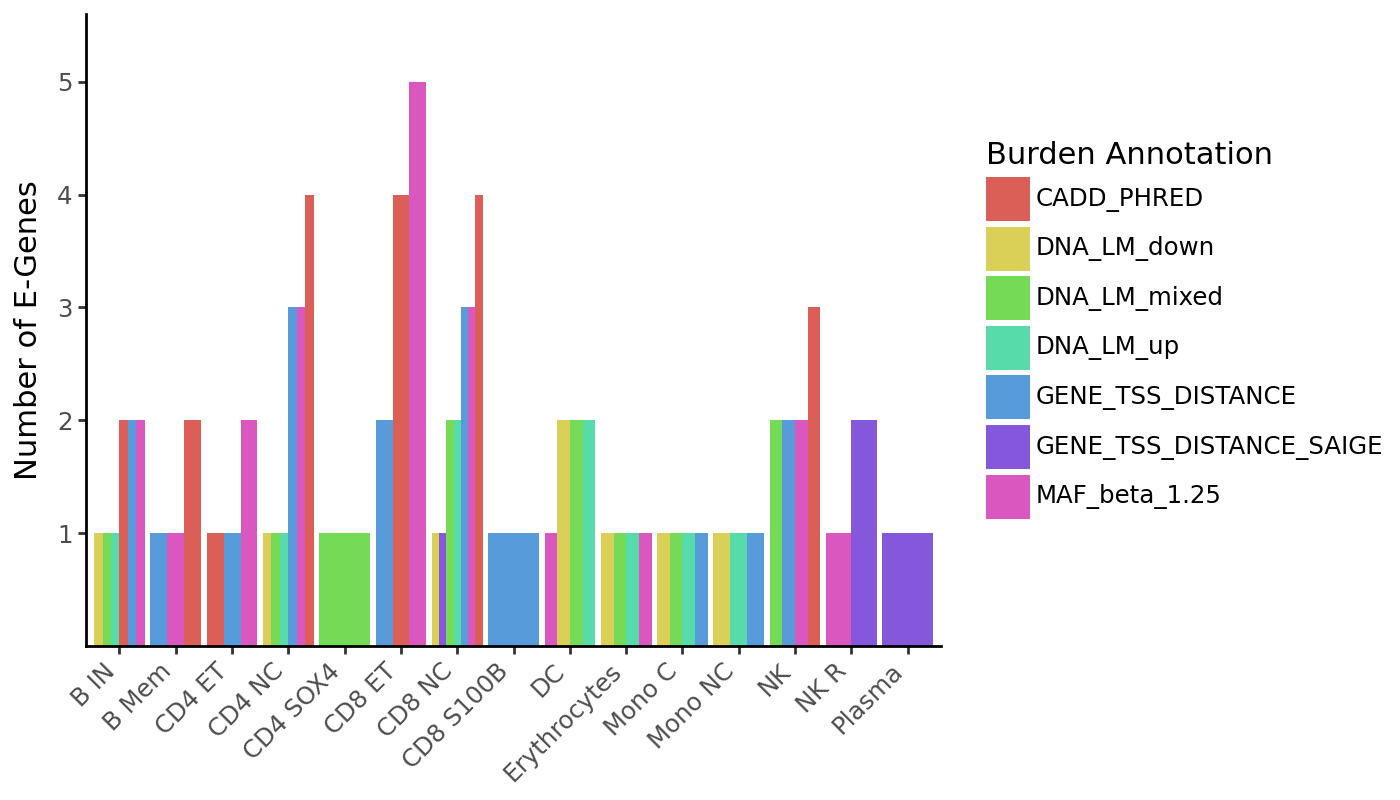

In [10]:
plot_egenes(df_to_plot_ET)

## QQ plots for burden type

In [11]:
def QQ_plot_sig_egenes(FDR_corrected_results, burdentype):
    """
    FDR_corrected_results: pd.DataFrame, output[0] of FDR_correction()
    burdentype: Str

    returns: QQ plot for given burden. Red line: uniform distributed pvalues. 
                                        in red: significant egens
    """
    df = FDR_corrected_results.copy().query("burden_type == @burdentype")

    df = df.sort_values("pvalue")
    df["-log10pval_expected"] = -np.log10(np.arange(1, len(df) + 1) / len(df))
    
    if "-log10pval" not in df.columns:
        df["-log10pval"] = -np.log10(df["pvalue"])
    
    aes_kwargs = dict(x="-log10pval_expected", y="-log10pval")
    plot = (
        ggplot(df, aes(**aes_kwargs, color="significant"))
        + labs(title=f"QQ plot for {burdentype}")
        + scale_color_manual(values = ["black", "red"])
        + theme_classic()
        + geom_abline(intercept=0, slope=1, color="red")
        + geom_point()
        + theme(legend_position="top", figure_size = (4,4))
    )
    return(plot)

[2025-01-27 15:21:24,007] INFO:matplotlib.font_manager: Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


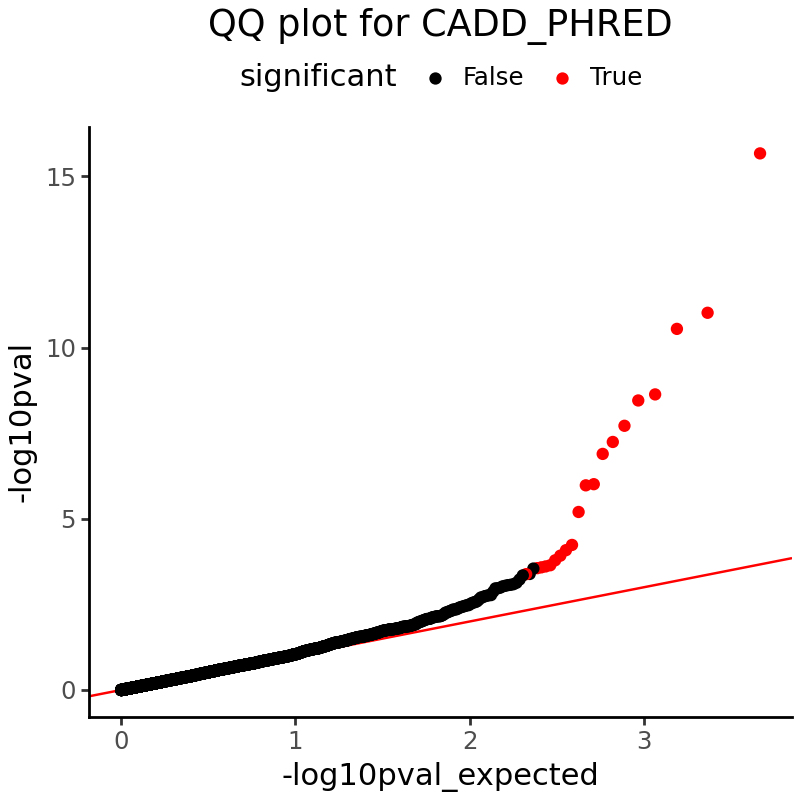

In [12]:
QQ_plot_sig_egenes(df_final_ET, "CADD_PHRED")

[2025-01-27 15:21:27,235] INFO:matplotlib.font_manager: Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


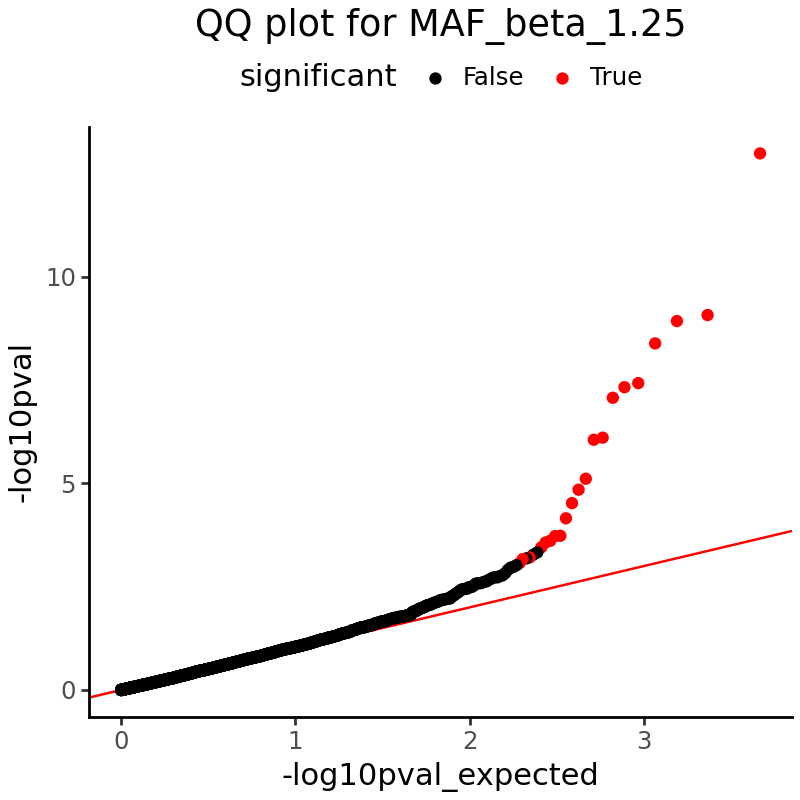

In [13]:
QQ_plot_sig_egenes(df_final_ET, "MAF_beta_1.25")

## Pseudobulk computation and plot recreation


In [14]:

from cellink.tl._eqtl import _get_pb_data

In [15]:
def get_pb_data_for_ct_per_gene(data, all_burdens, eigenvec, celltype, target_chrom):
    """
    data: DonorData object, annotated (output from run_data_annotation.py)
    all_burdens: pd.DataFrame, computed burden scores (output from run_compute_burdens.py)
    eigenvec: pd.DataFrame 
                (eigenvec = pd.read_csv("/s/project/sys_gen_students/2024_2025/project04_rare_variant_sc/input_data/pcdir/wgs.dose.filtered.R2_0.8.filtered.pruned.eigenvec", sep=' ', header=None)
    celltype: Str, cell type for which pb are computed
    target_chrom: Str

    returns: pb_by_gene_df, pd.DataFrame: sample id, pb_geneexpressions
    """
    eigenvec.index = eigenvec[1]
    eigenvec = eigenvec.iloc[:, 2:]
    eigenvec = eigenvec[eigenvec.index.isin(all_burdens.index.unique())]

    pb_data=_get_pb_data(
        scdata=data.adata,
        gdata=data.gdata,
        cell_type= celltype,
        target_chromosome= target_chrom,
        donor_key_in_scdata = "individual",
        sex_key_in_scdata = "sex",
        age_key_in_scdata = "age",
        pseudobulk_aggregation_type= "mean",
        min_individuals_threshold=10,
        n_top_genes = 5_000,
        n_sc_comps= 15,
        n_genetic_pcs= 20,
        n_cellstate_comps= 50,
        eigenvector_df=eigenvec
    )
    
    pb_data_all_genes = pb_data.adata.layers["mean"]
    pb_by_gene_df = pd.DataFrame(pb_data_all_genes, columns=pb_data.adata.var_names, index=pb_data.adata.obs_names)
    
    return(pb_by_gene_df)
    

In [16]:
def burdenscore_with_pb_expression(pb_by_gene_df, geneid, all_burdens, burden_type, celltype):
    """
    for a given gene, burdentype and celltype: combined info in one dataframe
    
    pb_by_gene_df: pd.DataFrame (output, get_pb_data_for_ct_per_gene)
    geneid: str
    all_burdens: pd.DataFrame, computed burden scores (output from run_compute_burdens.py)
    burden_type: Str
    celltype: Str (musst be the same as used in get_pb_data_for_ct_per_gene)

    returns: pd.DataFrame, cols: burdenscores, pb_expr, celltype
    """
    burden_type_gene=pd.DataFrame(all_burdens[all_burdens["Geneid"]==geneid][burden_type])
    # add pb expr
    burden_type_gene["pb_expr"]=pb_by_gene_df[geneid]
    burden_type_gene["cell_type"]= celltype
    return(burden_type_gene)
    

In [17]:
def plot_burden_expre_corr(burden_type_gene, burden_type, geneid):
    """
    plots the relation between pb expression and the burden score

    burden_type_gene:  pd.DataFrame (output, burdenscore_with_pb_expression, 
                            can be concatinated for multiple cell types)
    burden_type: Str 
    """
    plot = (
        ggplot(burden_type_gene, aes(x = burden_type, y = "pb_expr"))
        + labs(x = "Gene score",  title=f"Gene: {geneid}, annotation: {burden_type}")
        + theme_classic()
        + geom_smooth()
        + geom_point()
        + facet_wrap("cell_type", scales = "free")
        + theme(legend_position="top", figure_size = (5,5), plot_title=element_text(size=10))
    )
    plot
    return(plot)

In [18]:
data_chr22 = pd.read_pickle("/s/project/sys_gen_students/2024_2025/project04_rare_variant_sc/output/annotations/chr22_data.pkl")

chr22_all_burdens = pd.read_parquet("/s/project/sys_gen_students/2024_2025/project04_rare_variant_sc/output/burdens/chr22_all_burdens.parquet")

eigenvec = pd.read_csv("/s/project/sys_gen_students/2024_2025/project04_rare_variant_sc/input_data/pcdir/wgs.dose.filtered.R2_0.8.filtered.pruned.eigenvec", sep=' ', header=None)


In [19]:
pb_by_gene_df= get_pb_data_for_ct_per_gene(data_chr22, chr22_all_burdens, eigenvec, "NK R", "22")


[2025-01-27 15:22:12,676] INFO:cellink._core.donordata: Keeping 969/981 donors
[2025-01-27 15:22:12,677] INFO:cellink._core.donordata: Dropping 12/981 donors from genetic data
[2025-01-27 15:22:12,677] INFO:cellink._core.donordata: Dropping 0/969 donors from single-cell data


/opt/modules/i12g/anaconda/envs/mzb_scgenetics/lib/python3.10/site-packages/scanpy/preprocessing/_pca.py:317: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_eqtl.py:237: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_eqtl.py:237: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/opt/modules/i12g/anaconda/envs/mzb_scgenetics/lib/python3.10/site-packages/scanpy/preprocessing/_pca.py:377: FutureWarning: Argument `use_highly_variable` is d

In [20]:
pb_by_gene_df

Geneid     ENSG00000100181  ENSG00000177663  ENSG00000069998  ENSG00000093072  \
1_1               0.000000              0.0         0.000000         0.000000   
3_3               0.000000              0.0         0.000000         0.000000   
4_4               0.984683              0.0         0.000000         0.000000   
6_6               0.000000              0.0         0.000000         0.000000   
7_7               0.000000              0.0         0.000000         0.000000   
...                    ...              ...              ...              ...   
1077_1078         0.000000              0.0         0.429892         0.198523   
1078_1079         0.000000              0.0         0.000000         0.000000   
1079_1080         0.000000              0.0         0.660450         0.000000   
1080_1081         0.000000              0.0         0.000000         0.000000   
1081_1082         0.000000              0.0         1.394137         0.000000   

Geneid     ENSG00000131100  ENSG00000099968  ENSG00000015475  ENSG00000269220  \
1_1               0.000000         0.000000         0.000000         0.000000   
3_3               0.000000         0.000000         0.000000         0.000000   
4_4               0.473948         0.450681         0.481621         0.466926   
6_6               0.000000         0.000000         0.000000         0.000000   
7_7               1.086108         0.000000         1.086108         0.000000   
...                    ...              ...              ...              ...   
1077_1078         1.057405         0.000000         0.193553         0.195292   
1078_1079         0.000000         0.000000         0.000000         0.000000   
1079_1080         0.000000         0.000000         1.404805         0.644460   
1080_1081         0.000000         1.400779         0.000000         0.000000   
1081_1082         0.000000         2.819294         1.394137         0.000000   

Geneid     ENSG00000243156  ENSG00000215193  ...  ENSG00000100239  \
1_1               0.000000         0.000000  ...         0.000000   
3_3               0.000000         2.544693  ...         0.000000   
4_4               0.466926         0.000000  ...         0.000000   
6_6               0.000000         1.020249  ...         0.000000   
7_7               1.126083         0.000000  ...         0.000000   
...                    ...              ...  ...              ...   
1077_1078         0.219345         0.204735  ...         0.624066   
1078_1079         0.000000         5.812138  ...         0.000000   
1079_1080         0.000000         0.000000  ...         0.000000   
1080_1081         1.530374         0.000000  ...         1.400779   
1081_1082         1.288920         0.000000  ...         0.000000   

Geneid     ENSG00000100241  ENSG00000100258  ENSG00000025770  ENSG00000025708  \
1_1                    0.0         0.000000         0.000000         0.000000   
3_3                    0.0         0.000000         0.000000         0.000000   
4_4                    0.0         0.476427         0.000000         1.908843   
6_6                    0.0         0.000000         0.000000         1.063138   
7_7                    0.0         2.212191         1.126083         1.169188   
...                    ...              ...              ...              ...   
1077_1078              0.0         0.413704         0.000000         0.456997   
1078_1079              0.0         0.000000         0.000000         0.000000   
1079_1080              0.0         0.000000         0.000000         0.644460   
1080_1081              0.0         0.000000         0.000000         0.000000   
1081_1082              0.0         0.000000         0.000000         1.288920   

Geneid     ENSG00000177989  ENSG00000130487  ENSG00000100288  ENSG00000100299  \
1_1               0.000000         0.000000         0.000000         0.000000   
3_3               0.000000         0.000000         0.000000         0.000000   
4_4      

In [21]:
burdens_expr = burdenscore_with_pb_expression(pb_by_gene_df, "ENSG00000093000", chr22_all_burdens , "GENE_TSS_DISTANCE_SAIGE", "NK R")
burdens_expr

GENE_TSS_DISTANCE_SAIGE   pb_expr cell_type
id                                                    
1_1                      32.751909  0.000000      NK R
2_2                      30.026981       NaN      NK R
3_3                      22.219566  2.544693      NK R
4_4                      31.798172  0.000000      NK R
6_6                      28.401419  0.000000      NK R
...                            ...       ...       ...
1077_1078                20.440876  0.429164      NK R
1078_1079                42.742750  0.000000      NK R
1079_1080                24.595110  0.000000      NK R
1080_1081                46.450905  0.000000      NK R
1081_1082                30.241402  0.000000      NK R

[981 rows x 3 columns]

/opt/modules/i12g/anaconda/envs/mzb_scgenetics/lib/python3.10/site-packages/plotnine/stats/smoothers.py:347: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.
/opt/modules/i12g/anaconda/envs/mzb_scgenetics/lib/python3.10/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 12 rows containing missing values.


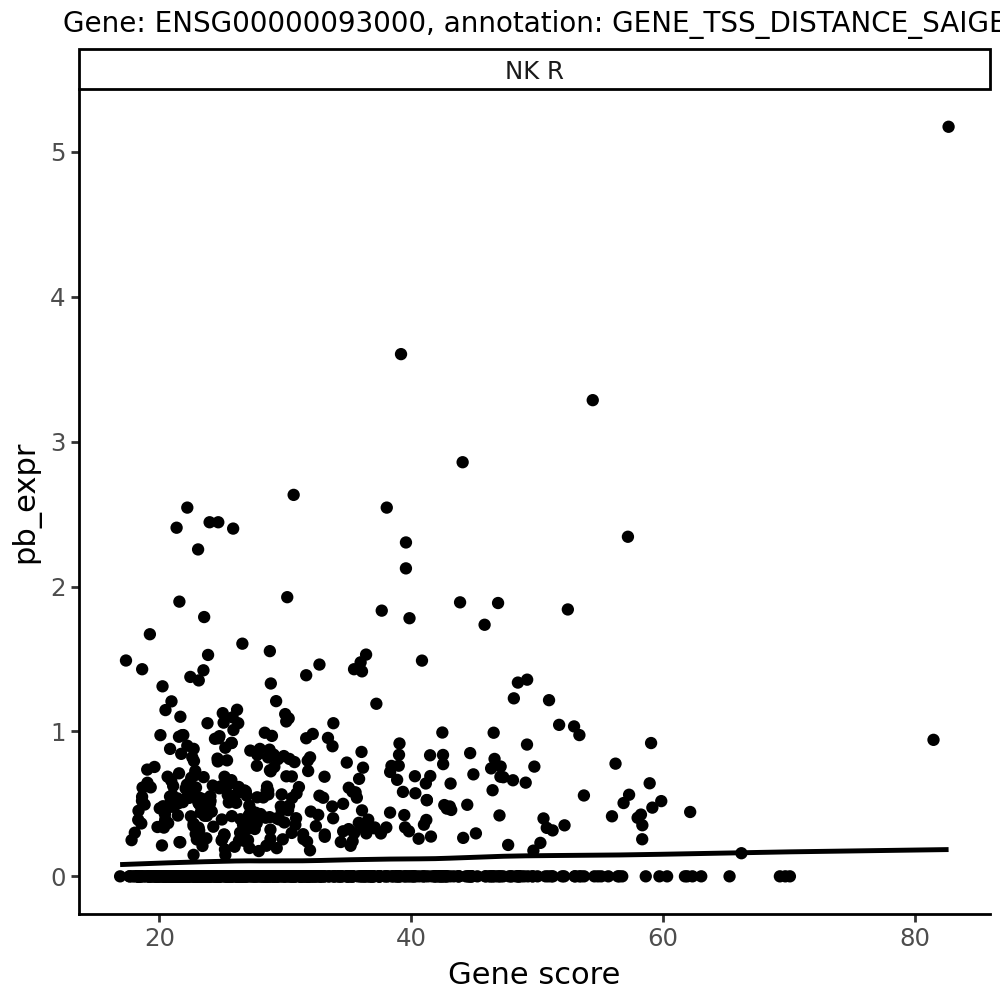

In [22]:
# here: multiple dfs of type burdens_expr could be concatinated
plot_burden_expre_corr(burdens_expr, burden_type="GENE_TSS_DISTANCE_SAIGE", geneid="ENSG00000093000")

In [23]:


def create_cor_plot(gene, cell_type, burden_type, chrom="22", data=data_chr22, burdens=chr22_all_burdens, eigenvec=eigenvec):
    pb_by_gene_df= get_pb_data_for_ct_per_gene(data, burdens, eigenvec, cell_type, chrom)
    burdens_expr = burdenscore_with_pb_expression(pb_by_gene_df, gene, burdens , burden_type, cell_type)
    return(plot_burden_expre_corr(burdens_expr, burden_type, gene))
    

In [24]:


def create_cor_plot(gene, cell_type, burden_type, chrom="22", data=data_chr22, burdens=chr22_all_burdens, eigenvec=eigenvec):
    pb_by_gene_df= get_pb_data_for_ct_per_gene(data, burdens, eigenvec, cell_type, chrom)
    burdens_expr = burdenscore_with_pb_expression(pb_by_gene_df, gene, burdens , burden_type, cell_type)
    return(plot_burden_expre_corr(burdens_expr, burden_type, gene))
    

In [25]:
df_final_ET[df_final_ET["significant"]]

burden_gene      target_gene    burden_type        pvalue      beta  \
0   ENSG00000185608  ENSG00000185608     CADD_PHRED  4.136143e-04 -0.042982   
0   ENSG00000244752  ENSG00000244752     CADD_PHRED  9.646785e-12  0.030304   
0   ENSG00000100284  ENSG00000100284     CADD_PHRED  2.465291e-04 -0.028984   
0   ENSG00000212939  ENSG00000212939     CADD_PHRED  2.277483e-04  0.027954   
3   ENSG00000177663  ENSG00000177663  MAF_beta_1.25  6.763201e-04  0.026120   
..              ...              ...            ...           ...       ...   
4   ENSG00000100307  ENSG00000100307   DNA_LM_mixed  5.597463e-05  0.305621   
1   ENSG00000128185  ENSG00000128185      DNA_LM_up  3.650636e-04  1.107529   
2   ENSG00000128185  ENSG00000128185    DNA_LM_down  4.647649e-04  1.080518   
3   ENSG00000128185  ENSG00000128185  MAF_beta_1.25  8.510478e-04  1.061162   
4   ENSG00000128185  ENSG00000128185   DNA_LM_mixed  4.455046e-04  1.084526   

       cell_type chromosome  significant  FDR_corrected  \
0         CD8 ET         22         True   3.815592e-02   
0         CD8 ET         22         True   3.559664e-09   
0         CD8 ET         22         True   3.032307e-02   
0         CD8 ET         22         True   3.032307e-02   
3         CD8 ET         22         True   4.991242e-02   
..           ...        ...          ...            ...   
4       CD4 SOX4         22         True   1.052323e-02   
1   Erythrocytes         22         True   1.241216e-02   
2   Erythrocytes         22         True   1.580201e-02   
3   Erythrocytes         22         True   2.893563e-02   
4   Erythrocytes         22         True   1.514716e-02   

           celltype-annotation  
0            CD8 ET-CADD_PHRED  
0            CD8 ET-CADD_PHRED  
0            CD8 ET-CADD_PHRED  
0            CD8 ET-CADD_PHRED  
3         CD8 ET-MAF_beta_1.25  
..                         ...  
4        CD4 SOX4-DNA_LM_mixed  
1       Erythrocytes-DNA_LM_up  
2     Erythrocytes-DNA_LM_down  
3   Erythrocytes-MAF_beta_1.25  
4    Erythrocytes-DNA_LM_mixed  

[90 rows x 10 columns]

/opt/modules/i12g/anaconda/envs/mzb_scgenetics/lib/python3.10/site-packages/scanpy/preprocessing/_pca.py:317: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_eqtl.py:237: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_eqtl.py:237: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/opt/modules/i12g/anaconda/envs/mzb_scgenetics/lib/python3.10/site-packages/scanpy/preprocessing/_pca.py:377: FutureWarning: Argument `use_highly_variable` is d

[2025-01-27 15:22:37,727] INFO:cellink._core.donordata: Keeping 981/981 donors
[2025-01-27 15:22:37,727] INFO:cellink._core.donordata: Dropping 0/981 donors from genetic data
[2025-01-27 15:22:37,727] INFO:cellink._core.donordata: Dropping 0/981 donors from single-cell data


/opt/modules/i12g/anaconda/envs/mzb_scgenetics/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
/opt/modules/i12g/anaconda/envs/mzb_scgenetics/lib/python3.10/site-packages/plotnine/stats/smoothers.py:347: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.


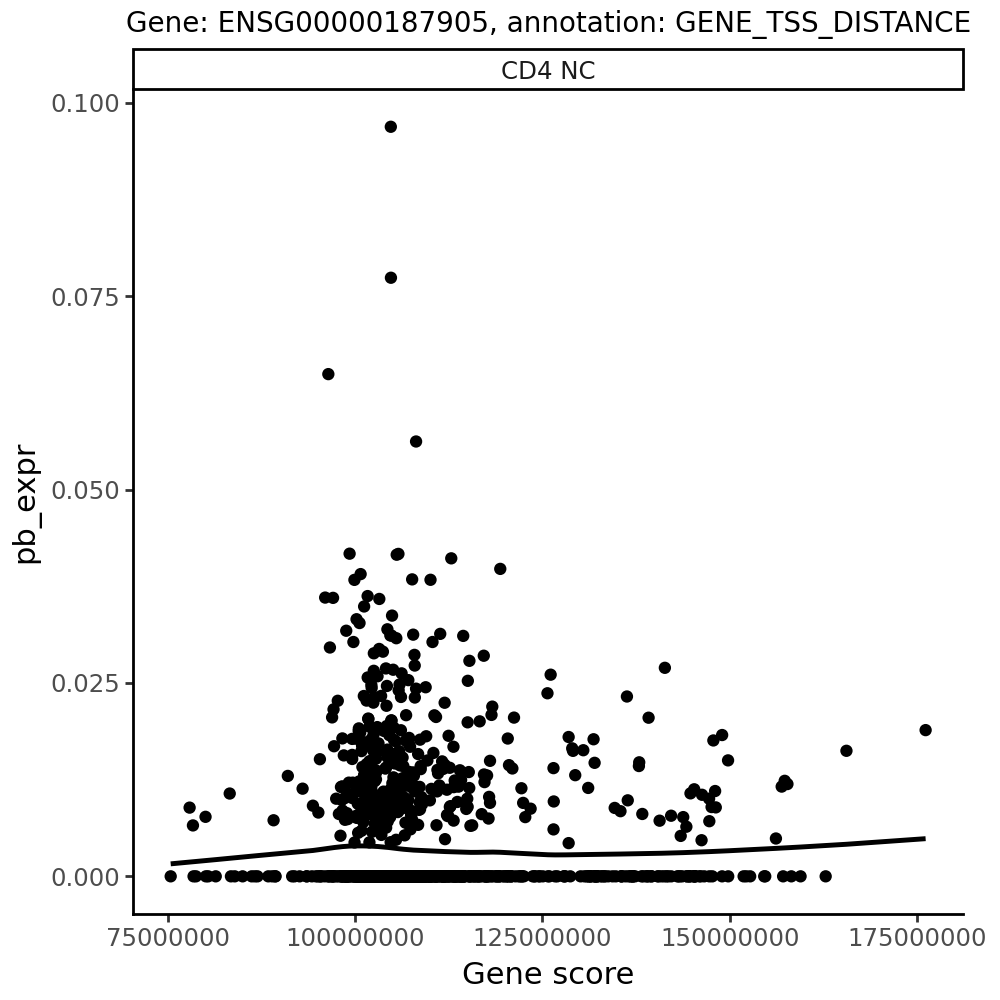

In [26]:
create_cor_plot(gene="ENSG00000187905", cell_type="CD4 NC", burden_type="GENE_TSS_DISTANCE")


In [27]:
df_final_ET[df_final_ET["significant"]].sort_values(by='FDR_corrected')

burden_gene      target_gene              burden_type        pvalue  \
5   ENSG00000244752  ENSG00000244752        GENE_TSS_DISTANCE  1.591353e-22   
5   ENSG00000244752  ENSG00000244752        GENE_TSS_DISTANCE  9.573160e-18   
0   ENSG00000244752  ENSG00000244752               CADD_PHRED  2.135824e-16   
5   ENSG00000244752  ENSG00000244752        GENE_TSS_DISTANCE  5.019416e-15   
3   ENSG00000244752  ENSG00000244752            MAF_beta_1.25  1.022285e-13   
..              ...              ...                      ...           ...   
3   ENSG00000244752  ENSG00000244752            MAF_beta_1.25  2.682350e-04   
5   ENSG00000184117  ENSG00000184117        GENE_TSS_DISTANCE  1.677499e-04   
6   ENSG00000198911  ENSG00000198911  GENE_TSS_DISTANCE_SAIGE  1.808751e-04   
3   ENSG00000185608  ENSG00000185608            MAF_beta_1.25  6.192517e-04   
3   ENSG00000177663  ENSG00000177663            MAF_beta_1.25  6.763201e-04   

        beta cell_type chromosome  significant  FDR_corrected  \
5   0.031611    CD4 NC         22         True   6.540460e-20   
5   0.037962    CD8 ET         22         True   3.532496e-15   
0   0.026757    CD4 NC         22         True   8.778237e-14   
5   0.038019        NK         22         True   1.902359e-12   
3   0.024315    CD4 NC         22         True   4.201591e-11   
..       ...       ...        ...          ...            ...   
3   0.021058      B IN         22         True   4.466113e-02   
5   0.141070   Mono NC         22         True   4.764098e-02   
6   0.276008    Plasma         22         True   4.829365e-02   
3  -0.041629    CD8 ET         22         True   4.991242e-02   
3   0.026120    CD8 ET         22         True   4.991242e-02   

               celltype-annotation  
5         CD4 NC-GENE_TSS_DISTANCE  
5         CD8 ET-GENE_TSS_DISTANCE  
0                CD4 NC-CADD_PHRED  
5             NK-GENE_TSS_DISTANCE  
3             CD4 NC-MAF_beta_1.25  
..                             ...  
3               B IN-MAF_beta_1.25  
5        Mono NC-GENE_TSS_DISTANCE  
6   Plasma-GENE_TSS_DISTANCE_SAIGE  
3             CD8 ET-MAF_beta_1.25  
3             CD8 ET-MAF_beta_1.25  

[90 rows x 10 columns]

In [31]:
#this_ddata_cd.gdata.obsm["pseudo_mean"][gene_oi] 
pbdata=compute_pb_data(data_chr22, chr22_all_burdens, eigenvec, "NK R", "22")

/opt/modules/i12g/anaconda/envs/mzb_scgenetics/lib/python3.10/site-packages/scanpy/preprocessing/_pca.py:317: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_eqtl.py:237: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_eqtl.py:237: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/opt/modules/i12g/anaconda/envs/mzb_scgenetics/lib/python3.10/site-packages/scanpy/preprocessing/_pca.py:377: FutureWarning: Argument `use_highly_variable` is d

[2025-01-27 17:49:44,648] INFO:cellink._core.donordata: Keeping 969/981 donors
[2025-01-27 17:49:44,649] INFO:cellink._core.donordata: Dropping 12/981 donors from genetic data
[2025-01-27 17:49:44,649] INFO:cellink._core.donordata: Dropping 0/969 donors from single-cell data


In [30]:
def compute_pb_data(data, all_burdens, eigenvec, celltype, target_chrom):
    """
    data: DonorData object, annotated (output from run_data_annotation.py)
    all_burdens: pd.DataFrame, computed burden scores (output from run_compute_burdens.py)
    eigenvec: pd.DataFrame 
                (eigenvec = pd.read_csv("/s/project/sys_gen_students/2024_2025/project04_rare_variant_sc/input_data/pcdir/wgs.dose.filtered.R2_0.8.filtered.pruned.eigenvec", sep=' ', header=None)
    celltype: Str, cell type for which pb are computed
    target_chrom: Str

    returns: pb_by_gene_df, pd.DataFrame: sample id, pb_geneexpressions
    """
    eigenvec.index = eigenvec[1]
    eigenvec = eigenvec.iloc[:, 2:]
    eigenvec = eigenvec[eigenvec.index.isin(all_burdens.index.unique())]

    pb_data=_get_pb_data(
        scdata=data.adata,
        gdata=data.gdata,
        cell_type= celltype,
        target_chromosome= target_chrom,
        donor_key_in_scdata = "individual",
        sex_key_in_scdata = "sex",
        age_key_in_scdata = "age",
        pseudobulk_aggregation_type= "mean",
        min_individuals_threshold=10,
        n_top_genes = 5_000,
        n_sc_comps= 15,
        n_genetic_pcs= 20,
        n_cellstate_comps= 50,
        eigenvector_df=eigenvec
    )
    return(pb_data)
    

In [41]:
#pb_data.adata.var_names, index=pb_data.adata.obs_names

adata[adata.obs['cell_type'] == 'CD8 ET', :]

ArrayView([[0.        , 0.        , 0.        , 0.        , 0.        ,
            0.        , 0.        , 0.        , 0.        , 0.        ],
           [0.        , 0.        , 0.        , 0.        , 0.        ,
            0.        , 0.        , 0.        , 0.        , 2.54469342],
           [0.98468333, 0.        , 0.        , 0.        , 0.47394784,
            0.45068065, 0.4816207 , 0.4669263 , 0.4669263 , 0.        ],
           [0.        , 0.        , 0.        , 0.        , 0.        ,
            0.        , 0.        , 0.        , 0.        , 1.02024925]])

In [38]:
pbdata.adata.obs_names

Index(['1_1', '3_3', '4_4', '6_6', '7_7', '8_8', '9_9', '10_10', '11_11',
       '12_12',
       ...
       '1072_1073', '1073_1074', '1074_1075', '1075_1076', '1076_1077',
       '1077_1078', '1078_1079', '1079_1080', '1080_1081', '1081_1082'],
      dtype='object', length=969)